# Selection of levels to perturb in LES runs

The purpose of this work is to determine which two model levels should be perturbed in the LES runs, where we cannot perturb all levels due to computational expense. The idea is to find the two levels that provide the most information about the model response to perturbations.

Yi-Ling's SCM results are provided - they show normalised responses in temperature and specific humidity, to perturbations of temperature and specific humidity, by pressure level and model. Here I use these results to determine which two perturbation pressure levels provide the most 'explanatory' information for the full set of results.

## Setup and settings

In [23]:
quiet <- FALSE
require(data.table, quietly = quiet)
require(ggplot2, quietly = quiet)
require(stringr, quietly = quiet)
require(viridis, quietly = quiet)
require(foreach, quietly = quiet)
require(doParallel, quietly = quiet)

# Register for parallel processing with foreach.
registerDoParallel(detectCores())

# Clean workspace.
rm(list = ls())

In [24]:
results_dir <- "/g/data/up6/tr2908/LRF_SCM_results" # Directory containing matrix results.
textsize <- 20 # Plot font size.
surface_pressure <- 1013 # Surface pressure [hPa].
top_pressure <- 165 # Pressure of next level above 200 hPa [hPa].

## Read response data

Pressure levels are stored in a separate file to the other results. These are the pressure levels used by Kuang; they are assumed to correspond to each row and column in the response matrices. The actual pressure level for each row and column depends on the model used but Yi-Ling confirms that they are reasonably close to the pressure levels here so we use these values for this analysis. I assume that the pressure levels are the centre of each slice of vertical pressure and construct classes that do not overlap in order to determine the thickness of each vertical layer.

In [25]:
# Pressures are stored in their own file.
pres <- read.csv(paste(results_dir, "pressures", sep = "/"), header = FALSE)[, 1]
pressures <- round(pres, 0) # Display version rounded to have no decimal place.

Read the CSV files containing the model responses:

In [26]:
# Read all CSV files and parse filenames to get metadata.
responses <- NULL
for (file in list.files(results_dir, pattern = "*.csv", recursive = TRUE, full.names = TRUE)) {
    dat <- data.table(read.csv(file, header = FALSE))
    names(dat) <- as.character(pressures)

    dat[, response_pressure := pressures]

    meta <- str_match(basename(file), "M_inv_(.*)_(q|t)_(.*)_norm_kuang.csv")
    dat[, model := meta[1, 2]]
    dat[, response_variable := meta[1, 3]]
    dat[, pert_variable := meta[1, 4]]

    responses <- rbind(responses, dat)
}
rm(list = "dat")

# Rename metadata for display purposes.
responses[pert_variable == "dtdt", pert_variable := "Perturbed t"]
responses[pert_variable == "dqdt", pert_variable := "Perturbed q"]
responses[response_variable == "t", response_variable := "Response in t"]
responses[response_variable == "q", response_variable := "Response in q"]

# Reshape the array into long data.table form.
responses <- melt(responses, id.vars = c("model", "response_variable", "pert_variable", "response_pressure"))
setnames(responses, "variable", "pert_pressure")
setnames(responses, "value", "response")

Because the pressure levels have different thicknesses, we multiply each response by the level thickness in hPa before performing the fits. First determine the thickness of each layer, ensuring there is no overlap between layers.

In [27]:
# Calculate the thickness of each pressure layer.
p <- c(surface_pressure, pres, top_pressure)
dp <- rep(NA, length(pres))

# Find 'best fit' thicknesses that mean layers do not overlap.
for (i in 2:(length(p) - 1)) {
    diff_up <- (p[i] - p[i + 1]) / 2
    diff_down <- (p[i - 1] - p[i]) / 2
    dp[i - 1] <- min(c(diff_up, diff_down)) * 2
}

# Sanity checks.
stopifnot(all((pres - dp / 2)[1:(length(pres) - 1)] > pres[2:length(pres)]))
stopifnot(all((pres + dp / 2)[2:length(pres)] < pres[1:(length(pres) - 1)]))
stopifnot(!any((pres + dp / 2)[2:length(pres)] == (pres - dp / 2)[1:(length(pres) - 1)]))

Here is a plot of the vertical levels, to ensure that the derived values of $\delta p$ don't make levels that overlap. The horizontal red lines are the model surface pressure and the pressure of the centre of the next level above the top level we deal with here.

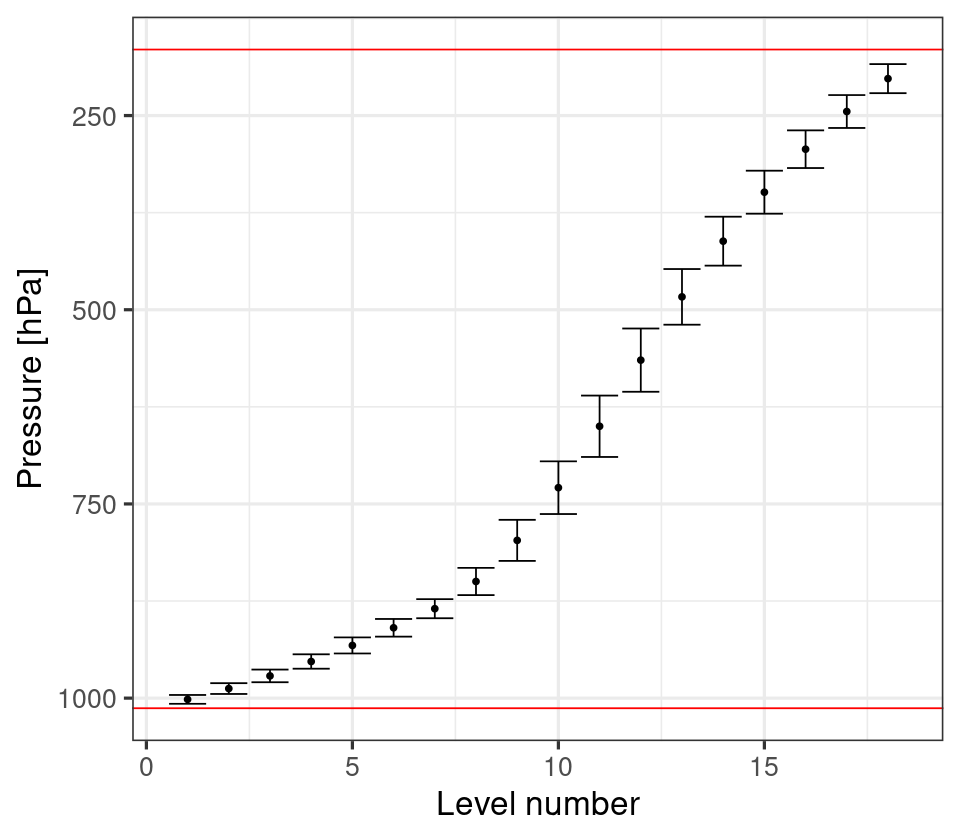

In [28]:
options(repr.plot.width = 8, repr.plot.height = 7)
p_levels <- data.table(level = seq(1, length(pressures)), p = pres, display_pressure = pressures, dp = dp)
ggplot(p_levels, aes(x = level, y = p)) +
    geom_errorbar(aes(ymin = p - dp / 2, ymax = p + dp / 2)) +
    geom_point() +
    theme_bw(textsize) +
    scale_y_continuous(trans = "reverse") +
    geom_hline(colour = "red", yintercept = surface_pressure) +
    geom_hline(colour = "red", yintercept = top_pressure) +
    labs(x = "Level number", y = "Pressure [hPa]")

Multiply each responses by the thickness of the response pressure layer:

In [29]:
setkey(p_levels, display_pressure)
setkey(responses, response_pressure)
responses[, response_dp := p_levels[responses, dp]]
responses[, orig_response := response]
responses[, response := response * response_dp]

## Plots of responses

Here is a plot showing the responses across pressure levels from perturbations at varying levels, for only the CNRM model. The vertical red line shows 0 response.

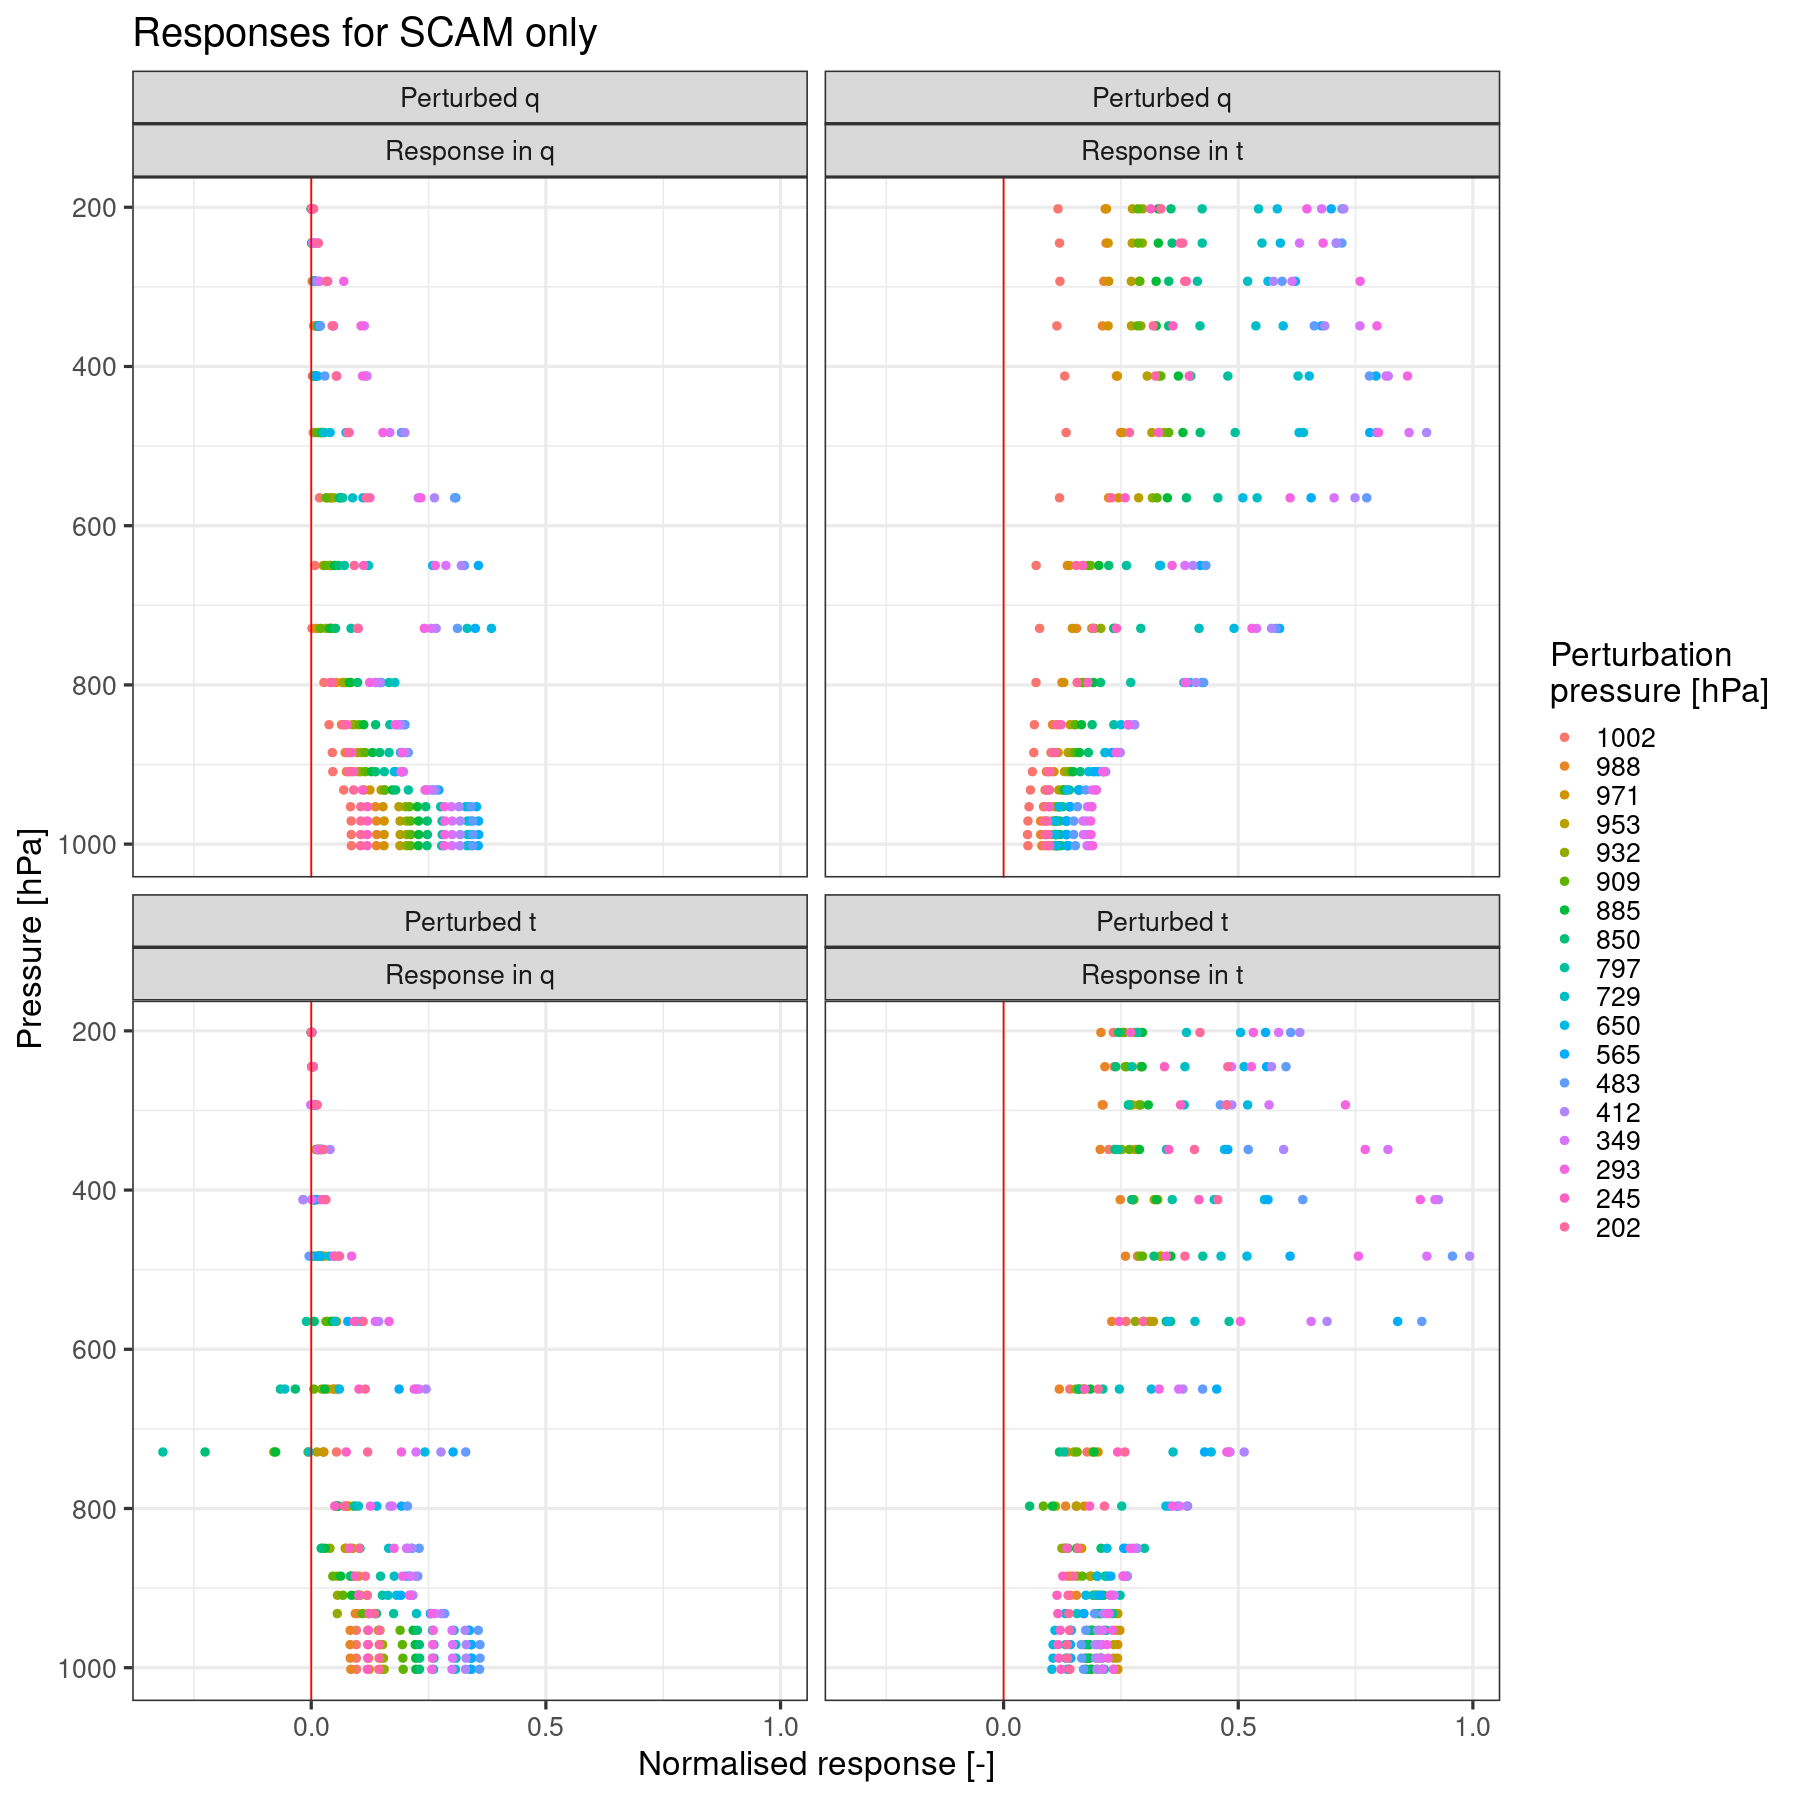

In [30]:
options(repr.plot.width = 15, repr.plot.height = 15)
ggplot(responses[model == "scam"], aes(x = orig_response, y = response_pressure)) +
    geom_point(aes(colour = pert_pressure), size = 2) +
    facet_wrap(pert_variable ~ response_variable) +
    labs(x = "Normalised response [-]", y = "Pressure [hPa]", title = "Responses for SCAM only") +
    scale_colour_discrete(name = "Perturbation\npressure [hPa]") +
    geom_vline(xintercept = 0, colour = "red") +
    theme_bw(textsize) +
    scale_y_continuous(trans = "reverse")

Here are the results for all models:

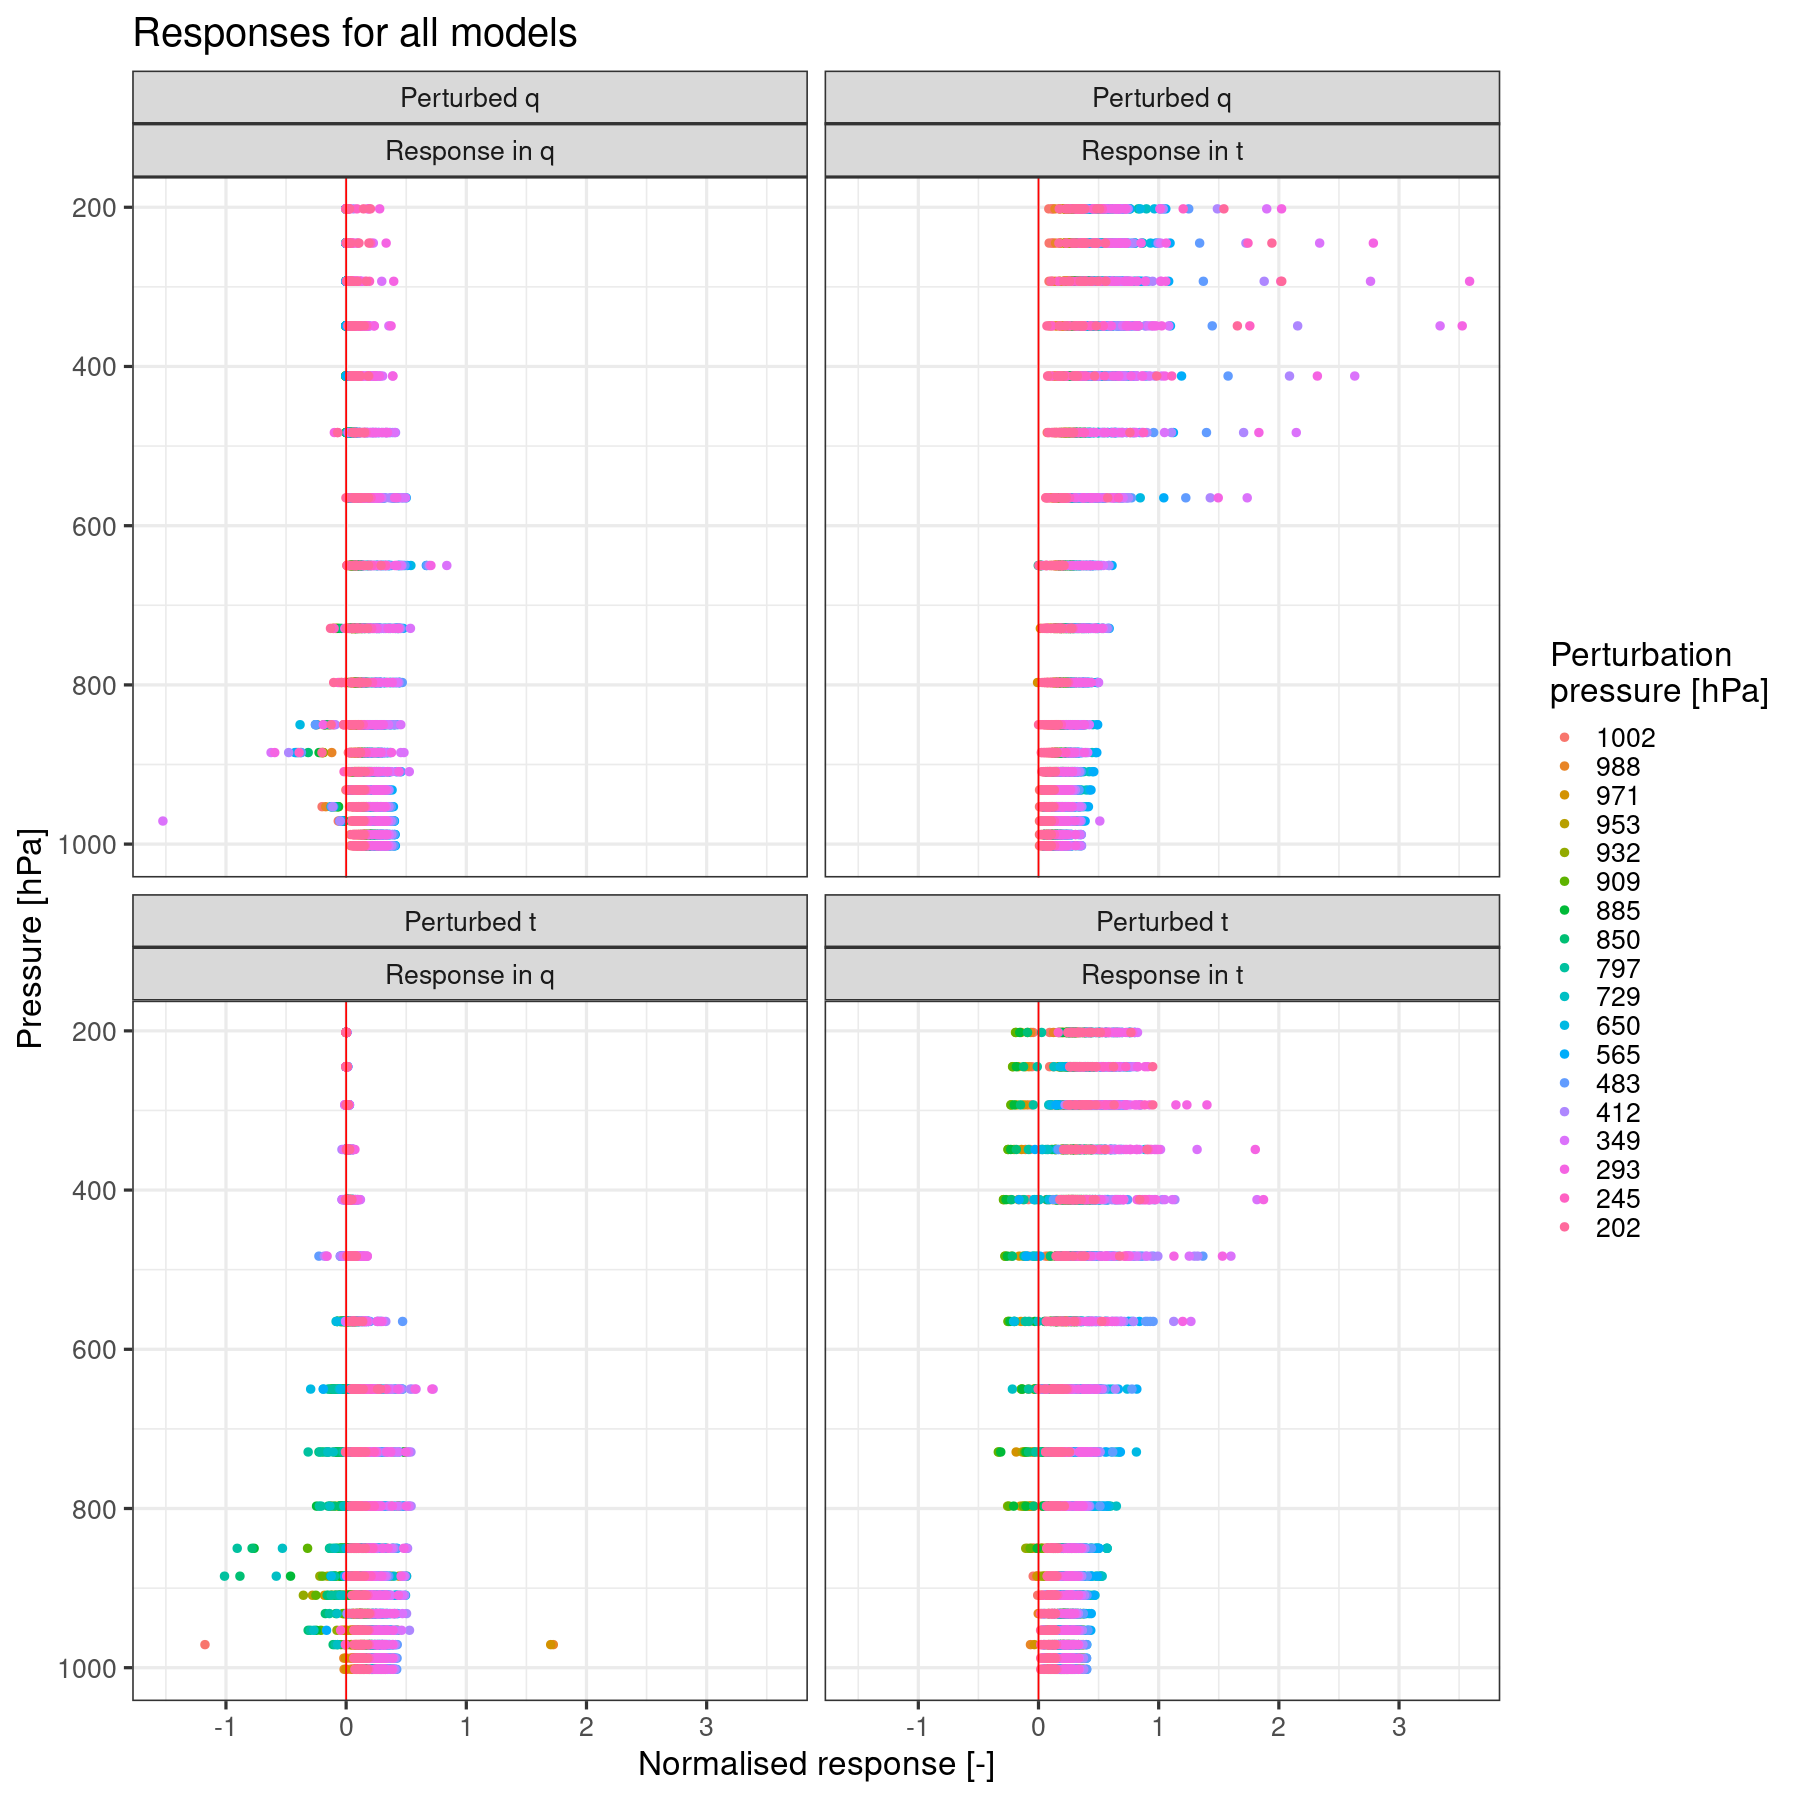

In [31]:
ggplot(responses, aes(x = orig_response, y = response_pressure)) +
    geom_point(aes(colour = pert_pressure), size = 2) +
    facet_wrap(pert_variable ~ response_variable) +
    labs(x = "Normalised response [-]", y = "Pressure [hPa]", title = "Responses for all models") +
    scale_colour_discrete(name = "Perturbation\npressure [hPa]") +
    geom_vline(xintercept = 0, colour = "red") +
    theme_bw(textsize) +
    scale_y_continuous(trans = "reverse")

## Tests of perturbation level combinations

Here we ask the question: *Which two perturbation level responses, when combined linearly, can best explain responses from all perturbation levels combined?*

Let $r(p_n, p_r)$ be a response at pressure level $r$, given a perturbation at pressure level $n$. Then the model I am fitting is

$$
r(p_x, p_r) = c_0 + c_1 r(p_1, p_r) + c_2 r(p_2, p_r)\quad\quad \forall x, r
$$

I test for all combinations of $p_1$ and $p_2$, for all data and for subsets of the data by perturbed and response variable. The "best" combination of $p_1$ and $p_2$ is the one for which the fitted linear model provides the highest $r^2$ value.

**Notes**
- I test both $r^2$ and 'adjusted $r^2$'; they are almost the same and provide the same optimal combinations.
- To do the test I construct a `data.table` containing for each response pressure and model `response_p1, response_p2, response` and I leave the responses from perturbing at $p_1$ and $p_2$ in the overall list of responses, meaning that the model is trained on all responses and not a subset with $p_1$ and $p_2$ removed.

In [32]:
res <- NULL

# Function to fit the linear model and return r2 values.
lm_fit <- function(dat) {
    fit <- lm(response ~ response_p1 + response_p2, data = dat)
    return(data.table::data.table(r2 = summary(fit)$r.squared, r2_adj = summary(fit)$adj.r.squared))
}

# Function to test a particular combination of perturbation pressures p1 and p2.
test_pert_pressures_triplet <- function(dat, p1, p2) {
    pert_pressure = NULL

    cols <- c("model", "response_variable", "pert_variable", "response_pressure")
    if (p1 == p2 || p1 > p2) {
        return(NULL)
    }

    # Subset for p1 and p2 perturbation pressures and combine into one data.table.
    subset_p1 <- dat[pert_pressure == p1]
    subset_p2 <- dat[pert_pressure == p2]
    data.table::setnames(subset_p1, "response", "response_p1")
    data.table::setnames(subset_p2, "response", "response_p2")
    subset_p1[, pert_pressure := NULL] #nolint
    subset_p2[, pert_pressure := NULL] #nolint
    data.table::setkeyv(subset_p1, cols)
    data.table::setkeyv(subset_p2, cols)
    subset <- subset_p1[subset_p2]

    # Add response_p1 and response_p2 as columns to all the input data.
    data.table::setkeyv(dat, cols)
    set <- dat[subset]

    # Fit to all data.
    fit_to_all <- cbind(data.table::data.table(response_variable = "All data", pert_variable = "All data"), lm_fit(set))

    # Fit per response and perturbation variable (combinations of q and t).
    fit_by_resp <- set[, lm_fit(.SD), by = c("response_variable", "pert_variable")] #nolint
    res <- cbind(data.table::data.table(p1 = p1, p2 = p2), rbind(fit_to_all, fit_by_resp))
    return(res)
}

test_fits <- function(dat, pressures, test_func = test_pert_pressures_triplet) {
    # Test the fit for each combination of two perturbation pressure levels.
    p_comb_results <- NULL
    for (p1 in pressures) {
        for (p2 in pressures) {
            p_comb_results <- rbind(p_comb_results, test_func(dat, p1 = p1, p2 = p2))
        }
    }
    p_comb_results[, p1 := factor(p1, levels = pressures)] #nolint
    p_comb_results[, p2 := factor(p2, levels = pressures)] #nolint

    # Determine best pressure level combination; the one with highest r2 value.
    best_pressures <- p_comb_results[, .SD[r2 == max(r2)], by = c("response_variable", "pert_variable")] #nolint
    best_pressures_adj <- p_comb_results[, .SD[r2_adj == max(r2_adj)], by = c("response_variable", "pert_variable")] #nolint
    stopifnot(best_pressures == best_pressures_adj)

    return(list(p_comb_results = p_comb_results, best_pressures = best_pressures))
}

In [33]:
all_data_results <- test_fits(responses, pressures)
column_results <- all_data_results$p_comb_results
best_pressures <- all_data_results$best_pressures
best_pressures[, set := "Best r2"]

Add `marked_pressures` which are comparison points to display on the plot of $r^2$ results.

In [34]:
marked_pressures <- copy(best_pressures)
marked_pressures <- marked_pressures[, r2 := NULL]
marked_pressures <- marked_pressures[, r2_adj := NULL]

hk <- copy(marked_pressures)
yl <- copy(marked_pressures)

hk[, set := "Herman and Kuang 2013"]
hk[, p1 := factor(729, levels = pressures)]
hk[, p2 := factor(850, levels = pressures)]

yl[, set := "Yi-Ling"]
yl[, p1 := factor(650, levels = pressures)]
yl[, p2 := factor(850, levels = pressures)]

marked_pressures <- rbind(marked_pressures, hk, yl)

## Results

Here's a plot of the resulting $r^2$ values per combination of perturbation pressure levels and for all data. The combination with the highest value of $r^2$ is marked with a red dot.

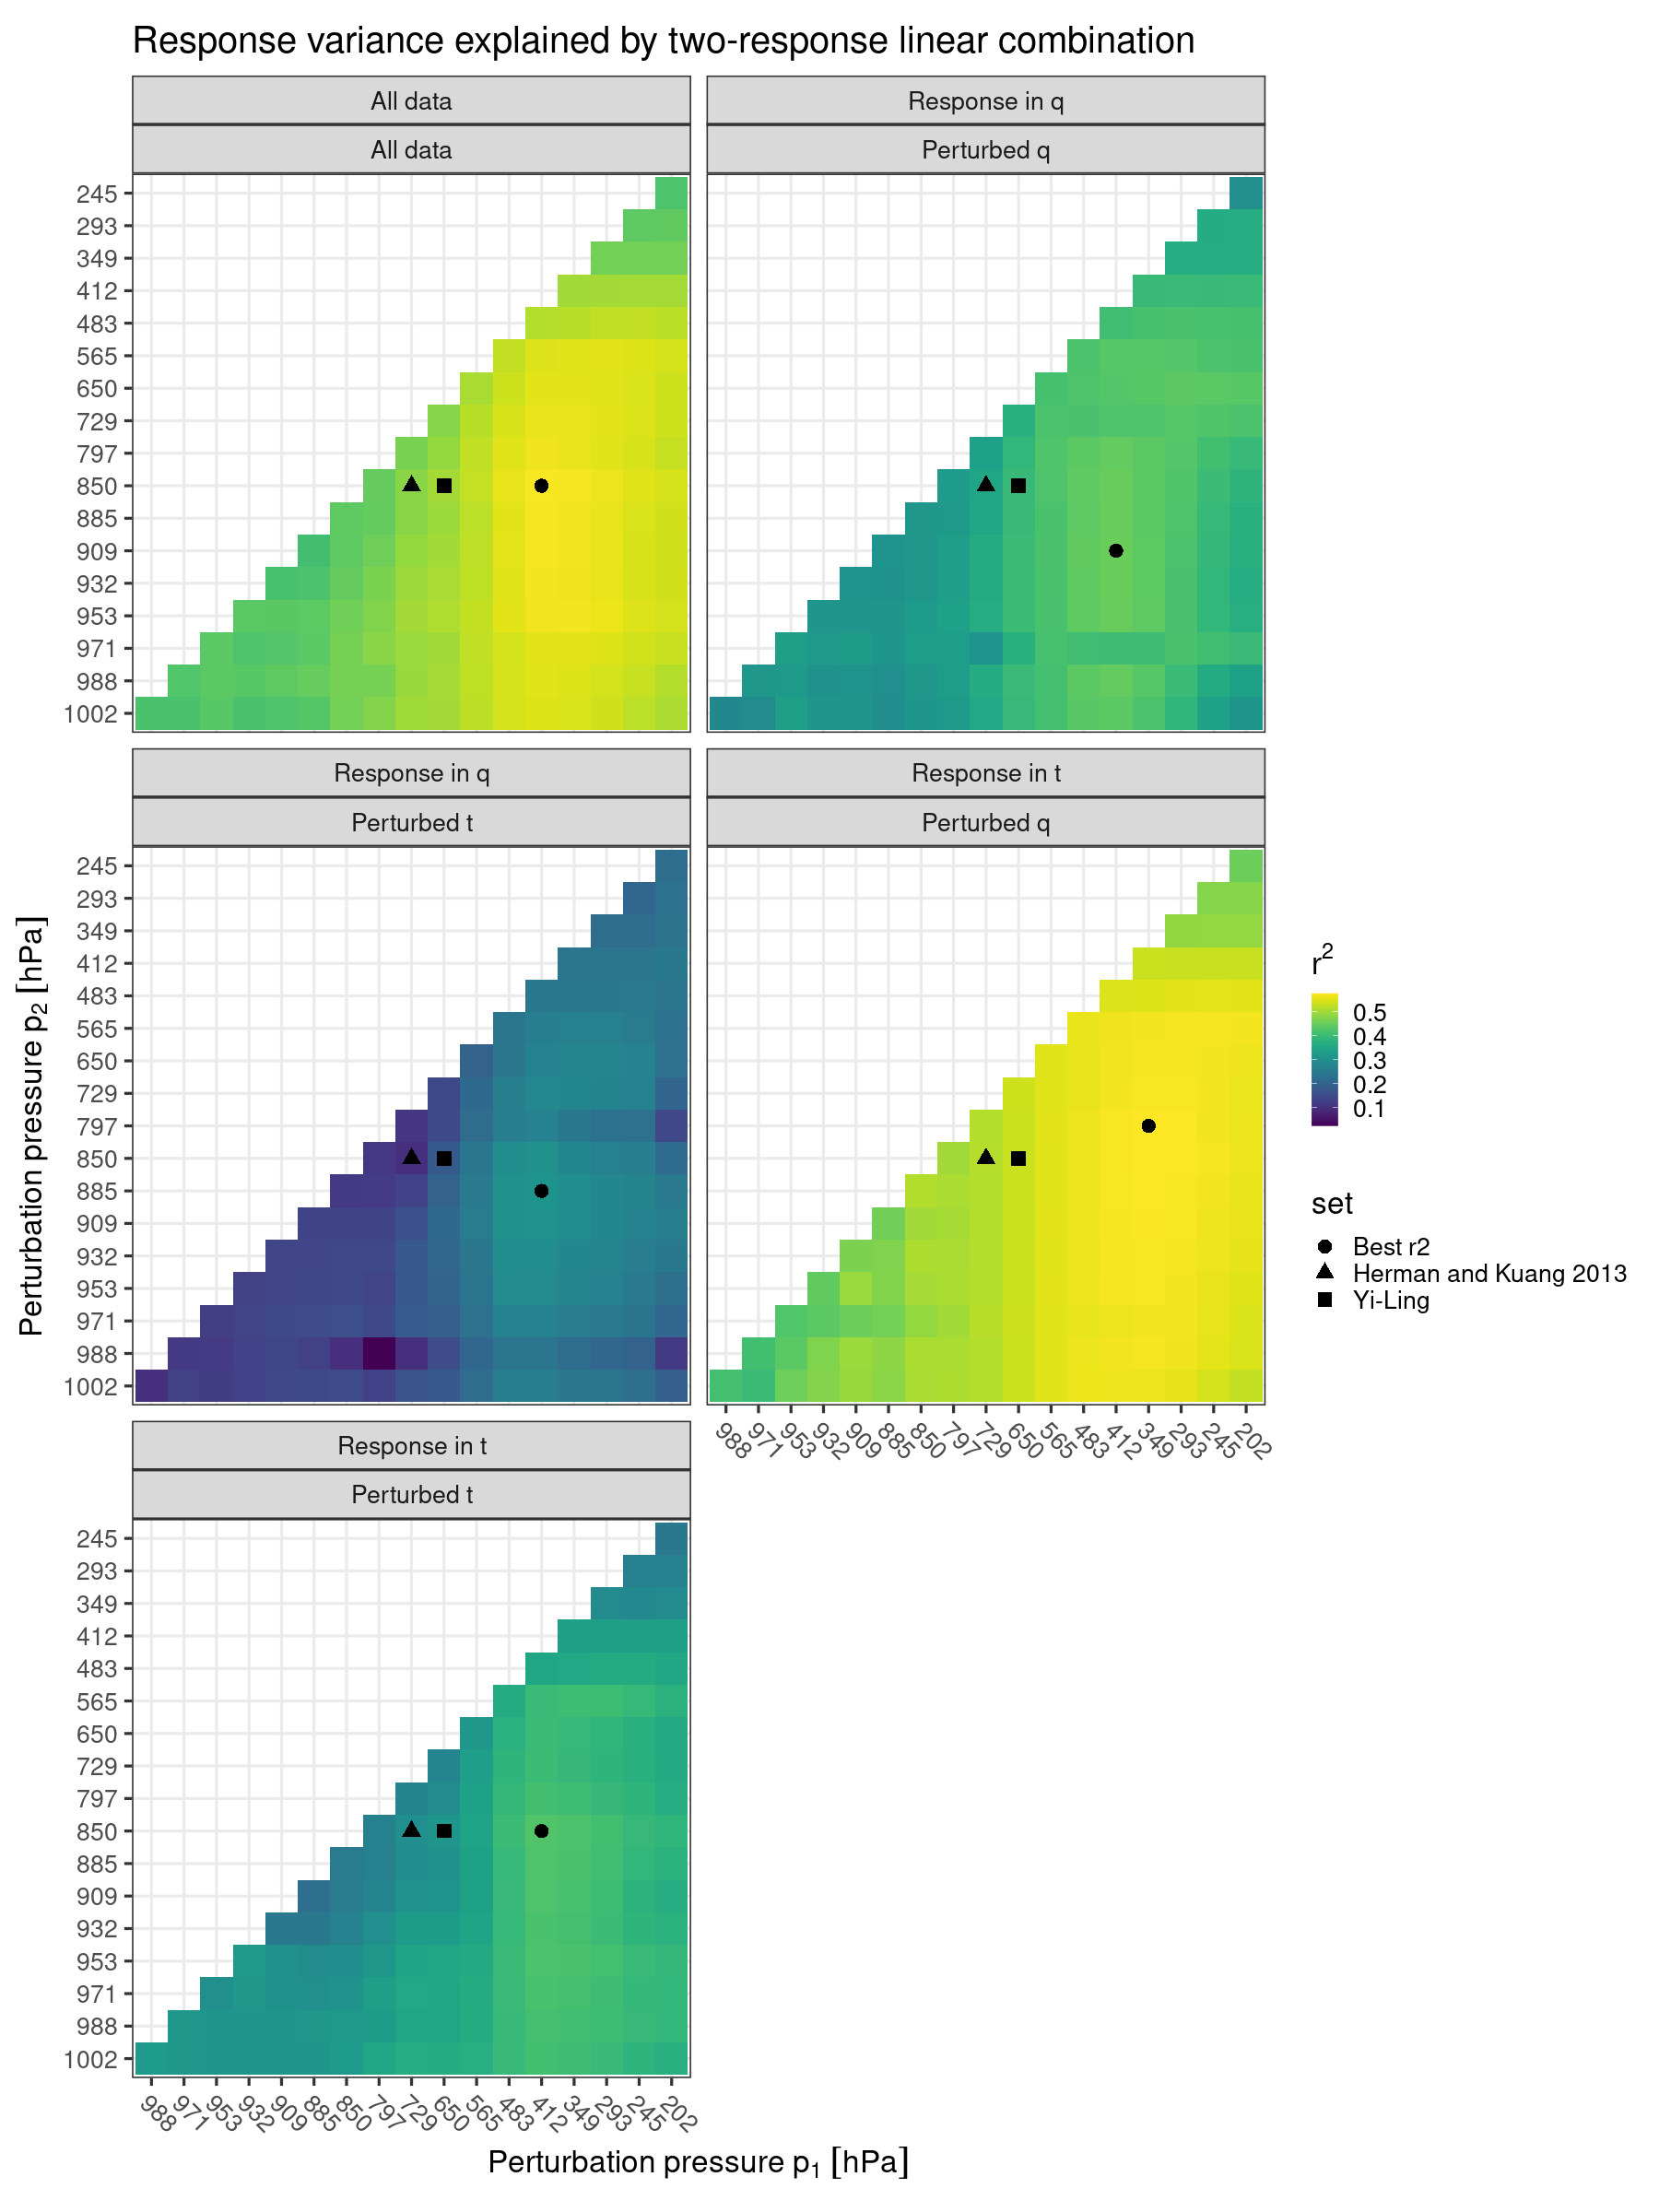

In [35]:
options(repr.plot.width = 15, repr.plot.height = 20)
ggplot(column_results, aes(x = p1, y = p2)) +
    geom_tile(aes(fill = r2)) +
    scale_fill_viridis(name = parse(text = "r^2")) +
    theme_bw(textsize) +
    theme(axis.text.x = element_text(angle = -45, hjust = 0, vjust = 1)) +
    geom_point(data = marked_pressures, colour = "black", aes(shape = set), size = 4) +
    labs(
        x = parse(text = "Perturbation~pressure~p[1]~group('[', hPa, ']')"),
        y = parse(text = "Perturbation~pressure~p[2]~group('[', hPa, ']')"),
        title = "Response variance explained by two-response linear combination"
    ) +
    facet_wrap(response_variable ~ pert_variable, ncol = 2) +
    coord_equal()

The best pressures for each combination are as follows:

In [36]:
print(best_pressures)

   response_variable pert_variable     p1     p2        r2    r2_adj     set
              <char>        <char> <fctr> <fctr>     <num>     <num>  <char>
1:          All data      All data    412    850 0.5708824 0.5708314 Best r2
2:     Response in q   Perturbed q    412    909 0.4497127 0.4494512 Best r2
3:     Response in q   Perturbed t    412    885 0.3085961 0.3082676 Best r2
4:     Response in t   Perturbed q    349    797 0.5756206 0.5754190 Best r2
5:     Response in t   Perturbed t    412    850 0.4248247 0.4245514 Best r2


Given these results a choice of 412 hPa and 850 hPa seems reasonable. The linear fit results for this combination are:

In [37]:
chosen_p = c(412, 850)
selected_results = column_results[p1 == chosen_p[1] & p2 == chosen_p[2]]
print(selected_results)

       p1     p2 response_variable pert_variable        r2    r2_adj
   <fctr> <fctr>            <char>        <char>     <num>     <num>
1:    412    850          All data      All data 0.5708824 0.5708314
2:    412    850     Response in q   Perturbed q 0.4487255 0.4484635
3:    412    850     Response in q   Perturbed t 0.2999689 0.2996363
4:    412    850     Response in t   Perturbed q 0.5708024 0.5705985
5:    412    850     Response in t   Perturbed t 0.4248247 0.4245514


And the difference between the "best" results for each response/perturbation variable combination and the results for this overall optimal chosen combination of pressure levels is small:

In [38]:
compare_to_best <- function(chosen_p, column_results, response_variable, pert_variable, best_pressures) {
    p1 <- p2 <- r2 <- i.r2 <- NULL # nolint
    selected_results <- column_results[p1 == chosen_p[1] & p2 == chosen_p[2]]
    data.table::setkey(selected_results, response_variable, pert_variable)
    data.table::setkey(best_pressures, response_variable, pert_variable)
    print(selected_results[best_pressures, list(response_variable, pert_variable, r2_diff = r2 - i.r2)])
}

compare_to_best(chosen_p, column_results, response_variable, pert_variable, best_pressures)

Key: <response_variable, pert_variable>
   response_variable pert_variable       r2_diff
              <char>        <char>         <num>
1:          All data      All data  0.0000000000
2:     Response in q   Perturbed q -0.0009872396
3:     Response in q   Perturbed t -0.0086271793
4:     Response in t   Perturbed q -0.0048181949
5:     Response in t   Perturbed t  0.0000000000


Here are the differences between the best $r^2$ perturbation levels and those used by Herman and Kuang 2013 (730 and 850 hPa, here 729 and 850 hPa):

In [39]:
compare_to_best(c(729, 850), column_results, response_variable, pert_variable, best_pressures)

Key: <response_variable, pert_variable>
   response_variable pert_variable     r2_diff
              <char>        <char>       <num>
1:          All data      All data -0.09204604
2:     Response in q   Perturbed q -0.09943068
3:     Response in q   Perturbed t -0.20900344
4:     Response in t   Perturbed q -0.06106614
5:     Response in t   Perturbed t -0.12878410


And here are differences between the best $r^2$ perturbation levels and those used by Yi-Ling (850 and 650 hPa):

In [40]:
compare_to_best(c(650, 850), column_results, response_variable, pert_variable, best_pressures)

Key: <response_variable, pert_variable>
   response_variable pert_variable     r2_diff
              <char>        <char>       <num>
1:          All data      All data -0.07048752
2:     Response in q   Perturbed q -0.05300100
3:     Response in q   Perturbed t -0.13162930
4:     Response in t   Perturbed q -0.04325220
5:     Response in t   Perturbed t -0.11337770


Here are the responses for the perturbation levels deemed overall the most explanatory:

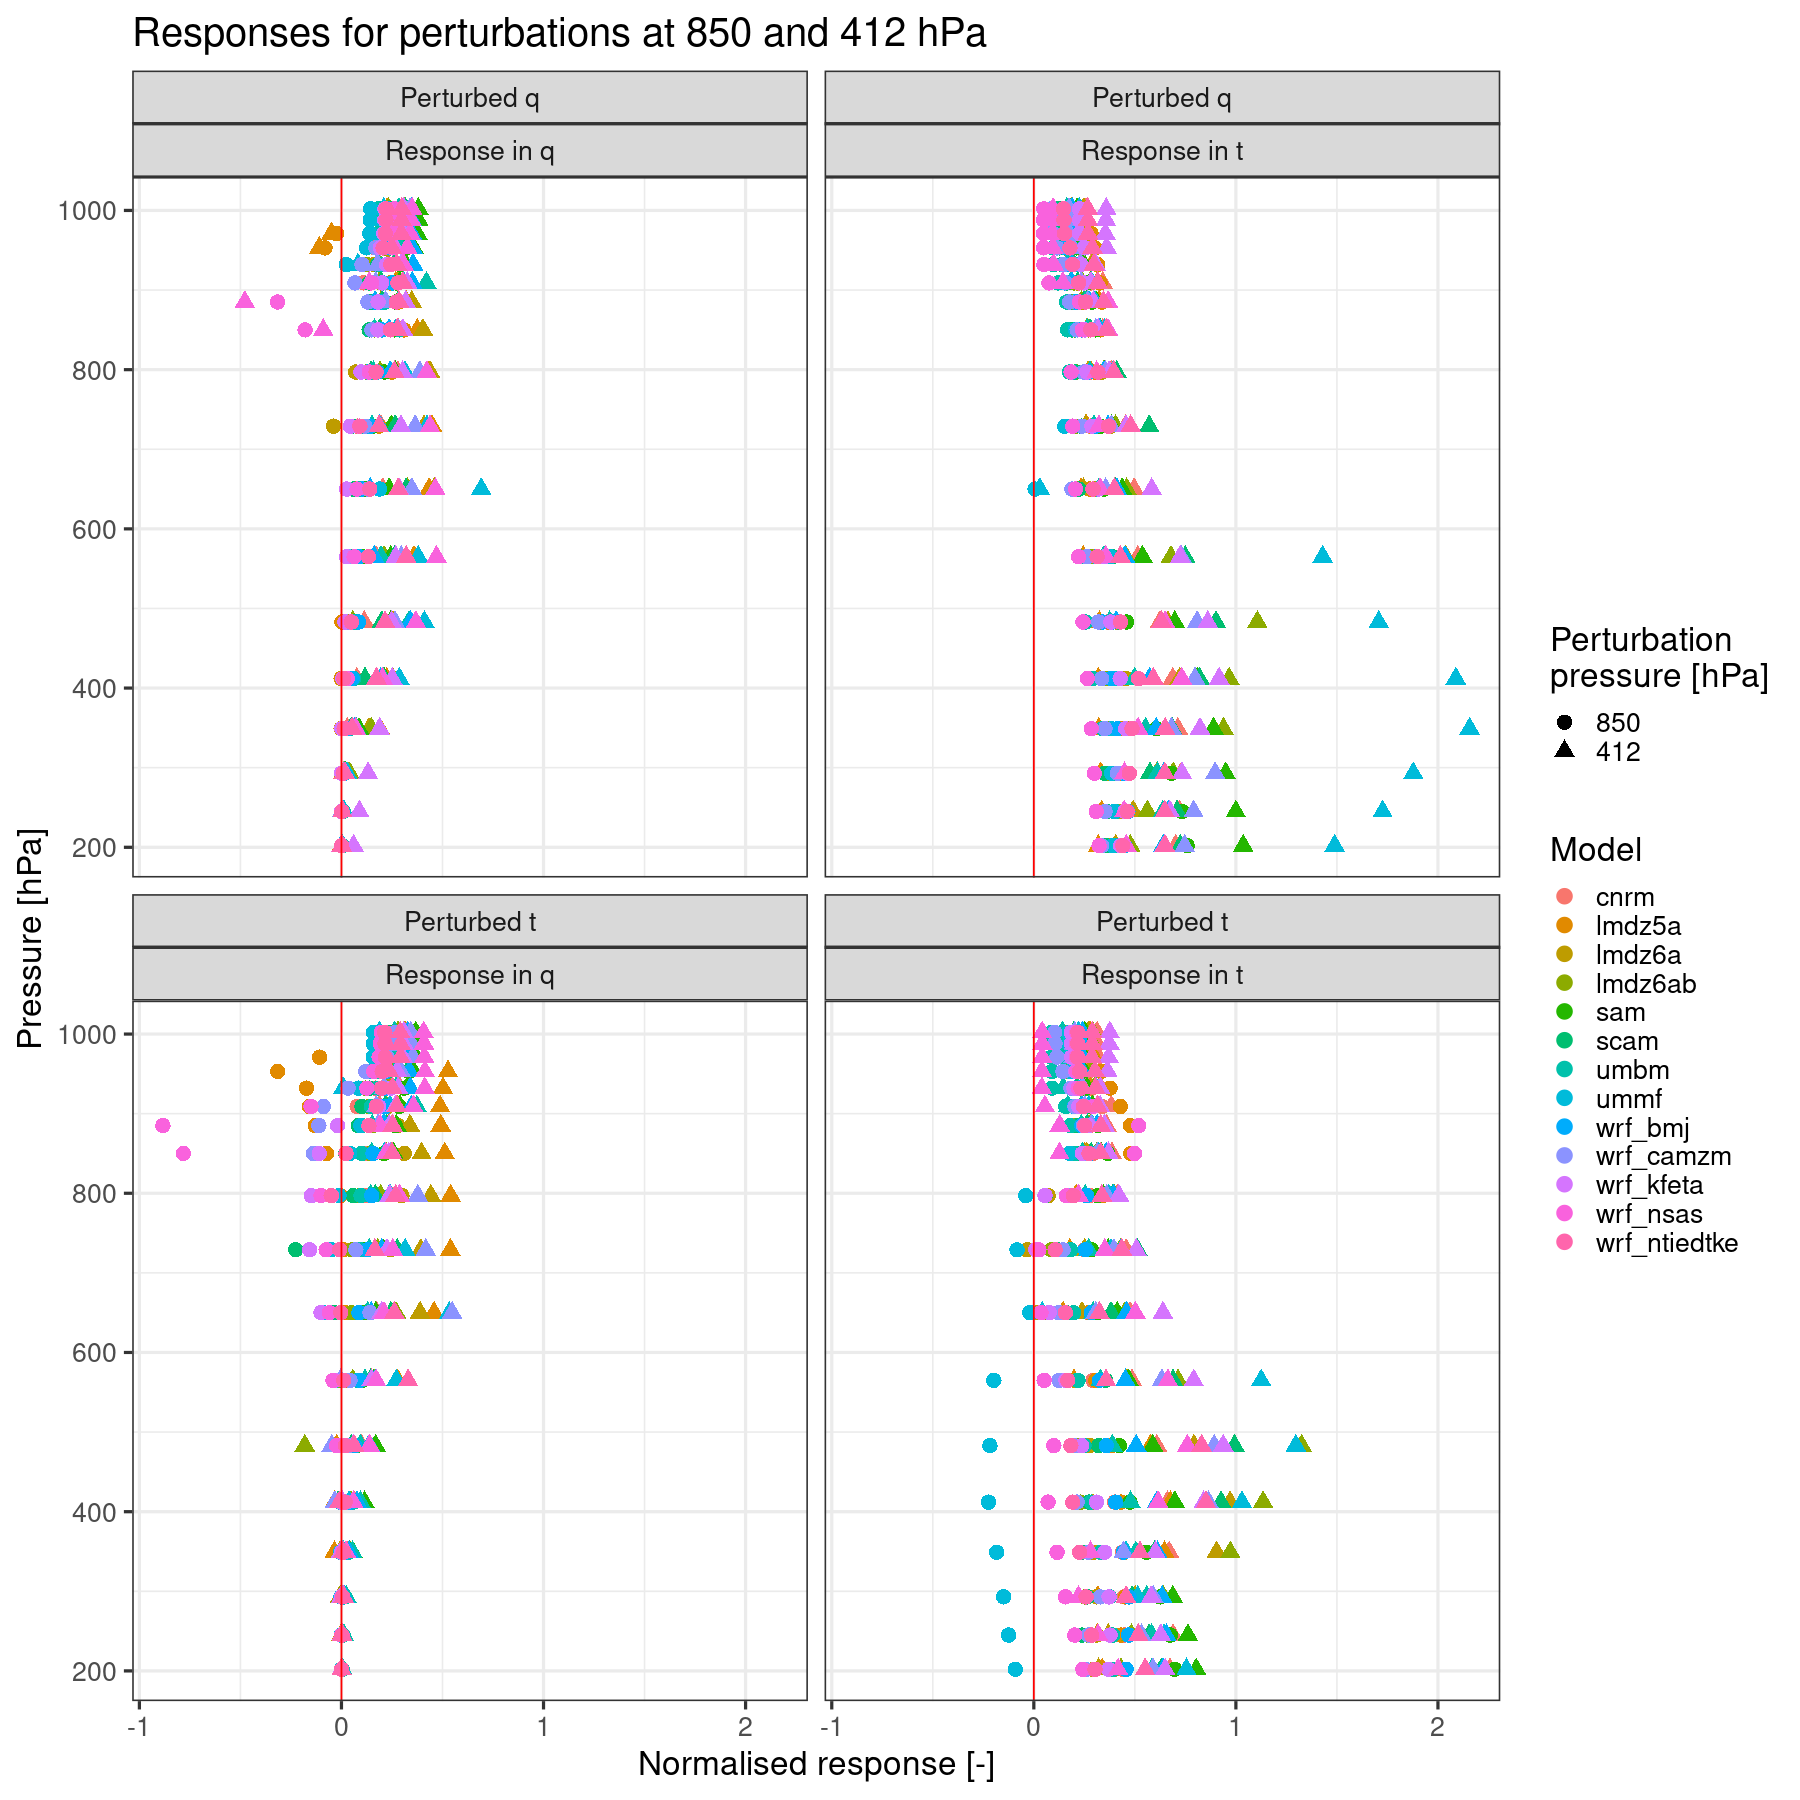

In [41]:
options(repr.plot.width = 15, repr.plot.height = 15)
ggplot(responses[pert_pressure %in% chosen_p], aes(x = orig_response, y = response_pressure)) +
    geom_point(aes(colour = model, shape = pert_pressure), size = 4) +
    facet_wrap(pert_variable ~ response_variable) +
    labs(x = "Normalised response [-]", y = "Pressure [hPa]",
         title = "Responses for perturbations at 850 and 412 hPa") +
    scale_colour_discrete(name = "Model") +
    scale_shape_discrete(name = "Perturbation\npressure [hPa]") +
    geom_vline(xintercept = 0, colour = "red") +
    theme_bw(textsize)

## Results with outlier models removed

There are two models that have large outliers -- UM-MF has outlier responses for temperature and WRF NSAS for specific humidity. Removing these two models and repeating the analysis:

In [42]:
subset_data_results <- test_fits(dat = responses[!(model %in% c("ummf", "wrf_nsas"))], pressures)
column_results_subset <- subset_data_results$p_comb_results
best_pressures_subset <- subset_data_results$best_pressures
print(best_pressures_subset)

   response_variable pert_variable     p1     p2        r2    r2_adj
              <char>        <char> <fctr> <fctr>     <num>     <num>
1:          All data      All data    412    850 0.6639705 0.6639234
2:     Response in q   Perturbed q    412    932 0.4379256 0.4376099
3:     Response in q   Perturbed t    412    885 0.3641692 0.3638121
4:     Response in t   Perturbed q    349    797 0.6864431 0.6862670
5:     Response in t   Perturbed t    412    850 0.5431782 0.5429217
